# 人脸关键点检测

作业：将此任务中的模型结构换成resnet18，网络结构见下图：

以下人脸关键点检测内容由@陈龙同学配合提供（可见官网-文档-教程-人脸关键点检测），感谢支持~


![](https://ai-studio-static-online.cdn.bcebos.com/bad3b96cdd6f4931989a79a1cbcbb263642759e4da7445aea754478af05cefc2)


## 一、简介
在图像处理中，关键点本质上是一种特征。它是对一个固定区域或者空间物理关系的抽象描述，描述的是一定邻域范围内的组合或上下文关系。它不仅仅是一个点信息，或代表一个位置，更代表着上下文与周围邻域的组合关系。关键点检测的目标就是通过计算机从图像中找出这些点的坐标，作为计算机视觉领域的一个基础任务，关键点的检测对于高级别任务，例如识别和分类具有至关重要的意义。

关键点检测方法总体上可以分成两个类型，一个种是用坐标回归的方式来解决，另一种是将关键点建模成热力图，通过像素分类任务，回归热力图分布得到关键点位置。这两个方法，都是一种手段或者是途径，解决的问题就是要找出这个点在图像当中的位置与关系。

其中人脸关键点检测是关键点检测方法的一个成功实践，本示例简要介绍如何通过飞桨开源框架，实现人脸关键点检测的功能。这个案例用到的是第一种关键点检测方法——坐标回归。将使用到 Paddle 2.1的API，集成式的训练接口，能够很方便对模型进行训练和预测。


## 二、环境设置

本教程基于Paddle 2.1 编写，如果你的环境不是本版本，请先参考官网[安装](https://www.paddlepaddle.org.cn/install/quick) Paddle 2.1 。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import paddle
from paddle.io import Dataset
from paddle.vision.transforms import transforms
from paddle.vision.models import resnet18
from paddle.nn import functional as F
print(paddle.__version__)

2.1.0


## 三、数据集
### 3.1 数据集下载
本案例使用了Kaggle官方举办的人脸关键点检测challenge数据集，官网：[https://www.kaggle.com/c/facial-keypoints-detection](https://www.kaggle.com/c/facial-keypoints-detection)

官方数据集将人脸图像和标注数据打包成了csv文件，使用panda来读取。其中数据集中的文件：<br>
training.csv: 包含了用于训练的人脸关键点坐标和图像。<br>
test.csv: 包含了用于测试的人脸关键点图像, 没有标注关键点坐标。<br>
IdLookupTable.csv: 测试集关键点的位置的对应名称。<br>

图像的长和宽都为96像素，所需要检测的一共有15个关键点。

In [3]:
!unzip -o ./test.zip -d data/data60
!unzip -o ./training.zip -d data/data60

Archive:  ./test.zip
  inflating: data/data60/test.csv    
Archive:  ./training.zip
  inflating: data/data60/training.csv  


### 3.2 数据集定义
飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。

首先进行数据集的定义，数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，__getitem__和__len__：

In [4]:
Train_Dir = './data/data60/training.csv'
Test_Dir = './data/data60/test.csv'
lookid_dir = './data/data60/IdLookupTable.csv'
class ImgTransforms(object):
    """
    图像预处理工具，用于将图像进行升维(96, 96) => (96, 96, 3)，
    并对图像的维度进行转换从HWC变为CHW
    """
    def __init__(self, fmt):
        self.format = fmt

    def __call__(self, img):
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
        img =  img.transpose(self.format)

        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        return img

class FaceDataset(Dataset):
    def __init__(self, data_path, mode='train', val_split=0.2):
        self.mode = mode
        assert self.mode in ['train', 'val', 'test'], \
            "mode should be 'train' or 'test', but got {}".format(self.mode)
        self.data_source = pd.read_csv(data_path)
        # 清洗数据, 数据集中有很多样本只标注了部分关键点, 这里有两种策略
        # 第一种, 将未标注的位置从上一个样本对应的关键点复制过来
        # self.data_source.fillna(method = 'ffill',inplace = True)
        # 第二种, 将包含有未标注的样本从数据集中移除
        self.data_source.dropna(how="any", inplace=True)  
        self.data_label_all = self.data_source.drop('Image', axis = 1)
        
        # 划分训练集和验证集合
        if self.mode in ['train', 'val']:
            np.random.seed(43)
            data_len = len(self.data_source)
            # 随机划分
            shuffled_indices = np.random.permutation(data_len)
            # 顺序划分
            # shuffled_indices = np.arange(data_len)
            self.shuffled_indices = shuffled_indices
            val_set_size = int(data_len*val_split)
            if self.mode == 'val':
                val_indices = shuffled_indices[:val_set_size]
                self.data_img = self.data_source.reindex().iloc[val_indices]
                self.data_label = self.data_label_all.reindex().iloc[val_indices]
            elif self.mode == 'train':
                train_indices = shuffled_indices[val_set_size:]
                self.data_img = self.data_source.reindex().iloc[train_indices]
                self.data_label = self.data_label_all.reindex().iloc[train_indices]
        elif self.mode == 'test':
            self.data_img = self.data_source
            self.data_label = self.data_label_all

        self.transforms = transforms.Compose([
            ImgTransforms((2, 0, 1))
        ])

    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):

        img = self.data_img['Image'].iloc[idx].split(' ')
        img = ['0' if x == '' else x for x in img]
        img = np.array(img, dtype = 'float32').reshape(96, 96)
        img = self.transforms(img)
        label = np.array(self.data_label.iloc[idx,:],dtype = 'float32')/96
        return img, label

    # 返回整个数据集的总数
    def __len__(self):
        return len(self.data_img)
# 训练数据集和验证数据集
train_dataset = FaceDataset(Train_Dir, mode='train')
val_dataset = FaceDataset(Train_Dir, mode='val')

# 测试数据集
test_dataset = FaceDataset(Test_Dir,  mode='test')

### 3.3 数据集抽样展示
实现好Dataset数据集后，来测试一下数据集是否符合预期，因为Dataset是一个可以被迭代的Class，通过for循环从里面读取数据来用matplotlib进行展示。关键点的坐标在数据集中进行了归一化处理，这里乘以图像的大小恢复到原始尺度，并用scatter函数将点画在输出的图像上。

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

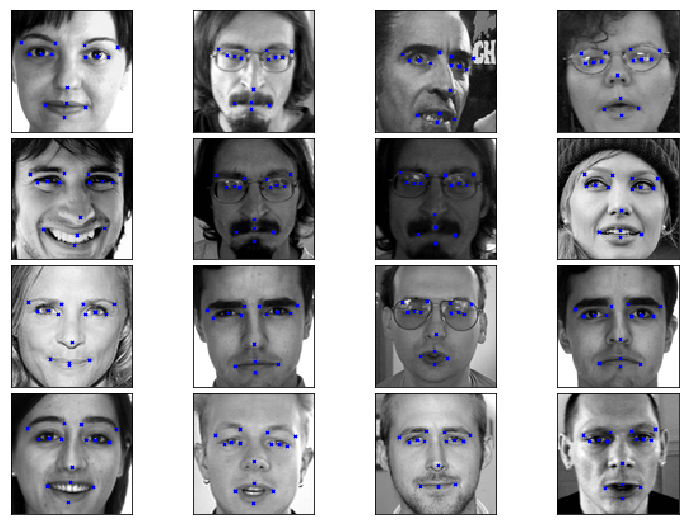

In [5]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='x', s=10, color='b')

fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 随机取16个样本展示
for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    idx = np.random.randint(train_dataset.__len__())
    # print(idx)
    img, label = train_dataset[idx]
    label = label*96
    plot_sample(img[0], label, axis)
plt.show()

## 四、定义模型
这里使用到 ``paddle.vision.models`` 中定义的 ``resnet18`` 网络模型。在ImageNet分类任务中，图像分成1000类，在模型后接一个全连接层，将输出的1000维向量映射成30维，对应15个关键点的横纵坐标。

### 更换预训练模型

In [6]:
import paddle.vision.models as m
dir(m)

['LeNet',
 'MobileNetV1',
 'MobileNetV2',
 'ResNet',
 'VGG',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lenet',
 'mobilenet_v1',
 'mobilenet_v2',
 'mobilenetv1',
 'mobilenetv2',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'vgg',
 'vgg11',
 'vgg13',
 'vgg16',
 'vgg19']

In [7]:
from paddle.vision.models import resnet18
class CNNFaceNet(paddle.nn.Layer):
    def __init__(self, num_keypoints):
        super(CNNFaceNet, self).__init__()
        self.backbone = resnet18(pretrained = True)
        self.outLayer1 = paddle.nn.Sequential(
            paddle.nn.Linear(1000, 512),
            paddle.nn.ReLU(),
            paddle.nn.Dropout(0.1)
        )
        self.outLayer2 = paddle.nn.Linear(512, num_keypoints*2)
    def forward(self, inputs):
        out1 = self.backbone(inputs)
        out2 = self.outLayer1(out1)
        out3 = self.outLayer2(out2)
        return out3

In [9]:
#import paddle.nn as nn

#class CNNFaceNet(nn.Layer):
#    def __init__(self, num_keypoints):
#        super(CNNFaceNet, self).__init__()
#        self.conv1 = nn.Conv2D(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.1)
#       self.bn1 = nn.BatchNorm2D(num_features=32)

#        self.conv2 = nn.Conv2D(in_channels=32, out_channels=32, kernel_size=3, padding=1)
#        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn2 = nn.BatchNorm2D(num_features=32)
#        self.maxpool1 = nn.MaxPool2D(kernel_size=2)

#        self.conv3 = nn.Conv2D(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#        self.leakyrelu3 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn3 = nn.BatchNorm2D(num_features=64)

#        self.conv4 = nn.Conv2D(in_channels=64, out_channels=64, kernel_size=3, padding=1)
#        self.leakyrelu4 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn4 = nn.BatchNorm2D(num_features=64)
#        self.maxpool2 = nn.MaxPool2D(kernel_size=2)

#        self.conv5 = nn.Conv2D(in_channels=64, out_channels=96, kernel_size=3, padding=1)
#        self.leakyrelu5 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn5 = nn.BatchNorm2D(num_features=96)

#        self.conv6 = nn.Conv2D(in_channels=96, out_channels=96, kernel_size=3, padding=1)
#        self.leakyrelu6 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn6 = nn.BatchNorm2D(num_features=96)
#        self.maxpool3 = nn.MaxPool2D(kernel_size=2)

#        self.conv7 = nn.Conv2D(in_channels=96, out_channels=96, kernel_size=3, padding=1)
#        self.leakyrelu7 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn7 = nn.BatchNorm2D(num_features=96)

#        self.conv8 = nn.Conv2D(in_channels=96, out_channels=128, kernel_size=3, padding=1)
#        self.leakyrelu8 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn8 = nn.BatchNorm2D(num_features=128)
#        self.maxpool4 = nn.MaxPool2D(kernel_size=2)

#        self.conv9 = nn.Conv2D(in_channels=128, out_channels=128, kernel_size=3, padding=1)
#        self.leakyrelu9 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn9 = nn.BatchNorm2D(num_features=128)

#        self.conv10 = nn.Conv2D(in_channels=128, out_channels=256, kernel_size=3, padding=1)
#        self.leakyrelu10 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn10 = nn.BatchNorm2D(num_features=256)
#        self.maxpool5 = nn.MaxPool2D(kernel_size=2)

#        self.conv11 = nn.Conv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1)
#        self.leakyrelu11 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn11 = nn.BatchNorm2D(num_features=256)

#        self.conv12 = nn.Conv2D(in_channels=256, out_channels=256, kernel_size=3, padding=1)
#        self.leakyrelu12 = nn.LeakyReLU(negative_slope=0.1)
#        self.bn12 = nn.BatchNorm2D(num_features=256)

#        self.flatten = nn.Flatten()

#        self.outLayer1 = paddle.nn.Sequential(
#            paddle.nn.Linear(256*3*3, 512),
#            paddle.nn.ReLU(),
#            paddle.nn.Dropout(0.1))
#        self.outLayer2 = paddle.nn.Linear(512, num_keypoints*2)

#    def forward(self, x):
        
#        x = self.bn1(self.leakyrelu1(self.conv1(x)))
#        x = self.bn2(self.leakyrelu2(self.conv2(x)))
#        x = self.maxpool1(x)
        
#        x = self.bn3(self.leakyrelu3(self.conv3(x)))
#        x = self.bn4(self.leakyrelu4(self.conv4(x)))
#        x = self.maxpool2(x)

#        x = self.bn5(self.leakyrelu5(self.conv5(x)))
#        x = self.bn6(self.leakyrelu6(self.conv6(x)))
#        x = self.maxpool3(x)

#        x = self.bn7(self.leakyrelu7(self.conv7(x)))
#        x = self.bn8(self.leakyrelu8(self.conv8(x)))
#        x = self.maxpool4(x)

#        x = self.bn9(self.leakyrelu9(self.conv9(x)))
#        x = self.bn10(self.leakyrelu10(self.conv10(x)))
#        x = self.maxpool5(x)        
        
#        x = self.bn11(self.leakyrelu11(self.conv11(x)))
#        x = self.bn12(self.leakyrelu12(self.conv12(x)))

#        x = self.flatten(x)

#        x = self.outLayer1(x)
#        x = self.outLayer2(x)

#        return x

### 4.1 模型可视化
调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。

In [8]:
from paddle.static import InputSpec

num_keypoints = 15
model = paddle.Model(CNNFaceNet(num_keypoints))
model.summary((1,3, 96, 96))

100%|██████████| 69183/69183 [00:02<00:00, 30468.25it/s]


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1         [[1, 3, 96, 96]]     [1, 64, 48, 48]         9,408     
   BatchNorm2D-1     [[1, 64, 48, 48]]     [1, 64, 48, 48]          256      
      ReLU-1         [[1, 64, 48, 48]]     [1, 64, 48, 48]           0       
    MaxPool2D-1      [[1, 64, 48, 48]]     [1, 64, 24, 24]           0       
     Conv2D-2        [[1, 64, 24, 24]]     [1, 64, 24, 24]        36,864     
   BatchNorm2D-2     [[1, 64, 24, 24]]     [1, 64, 24, 24]          256      
      ReLU-2         [[1, 64, 24, 24]]     [1, 64, 24, 24]           0       
     Conv2D-3        [[1, 64, 24, 24]]     [1, 64, 24, 24]        36,864     
   BatchNorm2D-3     [[1, 64, 24, 24]]     [1, 64, 24, 24]          256      
   BasicBlock-1      [[1, 64, 24, 24]]     [1, 64, 24, 24]           0       
     Conv2D-4        [[1, 64, 24, 24]]     [1, 64, 24, 24]    

{'total_params': 12227014, 'trainable_params': 12207814}

## 五、训练模型
在这个任务是对坐标进行回归，使用均方误差（Mean Square error ）损失函数`paddle.nn.MSELoss()`来做计算，飞桨2.1中，在nn下将损失函数封装成可调用类。这里使用paddle.Model相关的API直接进行训练，只需要定义好数据集、网络模型和损失函数即可。

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [9]:
model = paddle.Model(CNNFaceNet(num_keypoints=15))
optim = paddle.optimizer.Adam(learning_rate=1e-3,
    parameters=model.parameters())
model.prepare(optim, paddle.nn.MSELoss())
model.fit(train_dataset, val_dataset, epochs=60, batch_size=256)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/60


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 7/7 - loss: 0.2531 - 596ms/step
Eval begin...
step 2/2 - loss: 1.5545 - 454ms/step
Eval samples: 428
Epoch 2/60
step 7/7 - loss: 0.0524 - 562ms/step
Eval begin...
step 2/2 - loss: 0.4920 - 452ms/step
Eval samples: 428
Epoch 3/60
step 7/7 - loss: 0.0367 - 564ms/step
Eval begin...
step 2/2 - loss: 0.1369 - 436ms/step
Eval samples: 428
Epoch 4/60
step 7/7 - loss: 0.0265 - 548ms/step
Eval begin...
step 2/2 - loss: 0.0286 - 450ms/step
Eval samples: 428
Epoch 5/60
step 7/7 - loss: 0.0208 - 574ms/step
Eval begin...
step 2/2 - loss: 0.0090 - 435ms/step
Eval samples: 428
Epoch 6/60
step 7/7 - loss: 0.0186 - 545ms/step
Eval begin...
step 2/2 - loss: 0.0045 - 435ms/step
Eval samples: 428
Epoch 7/60
step 7/7 - loss: 0.0166 - 582ms/step
Eval begin...
step 2/2 - loss: 0.0033 - 443ms/step
Eval samples: 428
Epoch 8/60
step 7/7 - loss: 0.0150 - 552ms/step
Eval begin...
step 2/2 - loss: 0.0029 - 438ms/step
Eval samples: 428
Epoch 9/60
step 7/7 - loss: 0.0150 - 555ms/step
Eval begin...
step 2/2 - lo

## 六、模型预测
为了更好的观察预测结果，分别可视化验证集结果与标注点的对比，和在未标注的测试集的预测结果。
### 6.1 验证集结果可视化
红色的关键点为网络预测的结果， 绿色的关键点为标注的groundtrue。

In [10]:
result = model.predict(val_dataset, batch_size=1)

Predict begin...
step 428/428 [==============================] - 13ms/step         
Predict samples: 428


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """


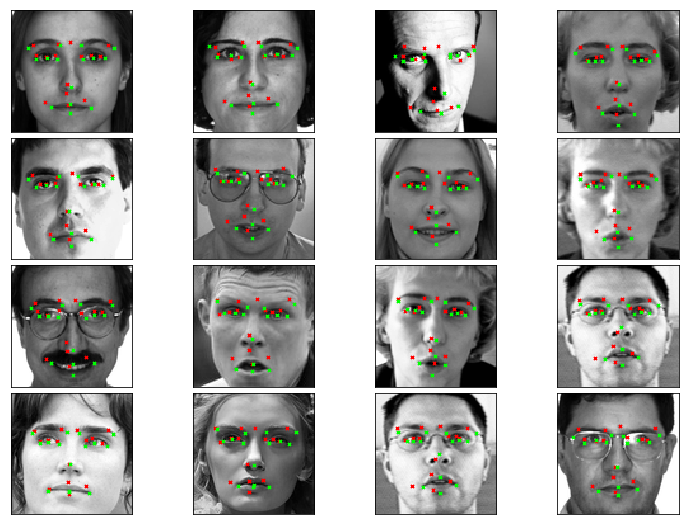

In [11]:
def plot_sample(x, y, axis, gt=[]):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='x', s=10, color='r')
    if gt!=[]:
        axis.scatter(gt[0::2], gt[1::2], marker='x', s=10, color='lime')


fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    idx = np.random.randint(val_dataset.__len__())
    img, gt_label = val_dataset[idx]
    gt_label = gt_label*96
    label_pred = result[0][idx].reshape(-1)
    label_pred = label_pred*96
    plot_sample(img[0], label_pred, axis, gt_label)
plt.show()

### 6.2 测试集结果可视化

In [12]:
result = model.predict(test_dataset, batch_size=1)

Predict begin...
step 1783/1783 [==============================] - 13ms/step        
Predict samples: 1783


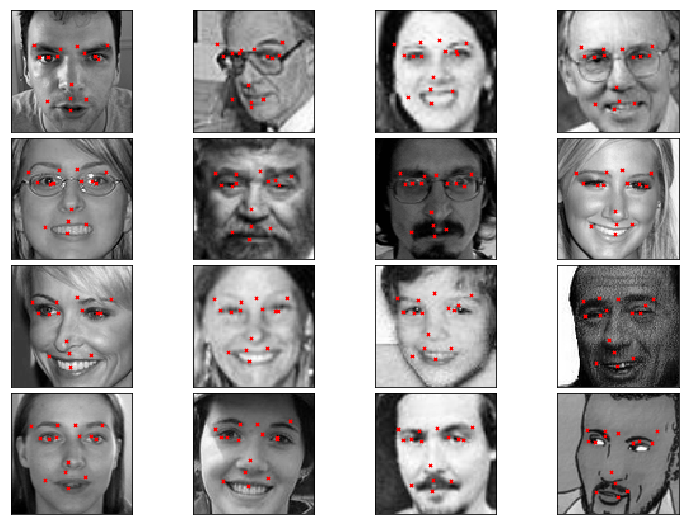

In [13]:
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    idx = np.random.randint(test_dataset.__len__())
    img, _ = test_dataset[idx]
    label_pred = result[0][idx].reshape(-1)
    label_pred = label_pred*96
    plot_sample(img[0], label_pred, axis)
plt.show()